In [1]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
from pycaret.classification import *

In [54]:
import shap

In [2]:
RANDOM_SEED = 123

In [3]:
df = pd.read_csv("F:/Data/datas/WA_Fn-UseC_-Telco-Customer-Churn.csv", index_col=0)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

**Fix Data Error**
- 0 tenure value causes the blank value in the total charges column and makes that column detected automatically as object data type
- We replace the blank string values with 0.0 float number

In [5]:
# Fix data type error
df.loc[df['tenure'] == 0, 'TotalCharges'] = 0.0
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print("Missing Values:", df['TotalCharges'].isna().sum())

Missing Values: 0


- We do split our data into train data and test data to prevent data leakage to test our model (even though the PyCaret itself already handles this data train-test split automatically to prevent the data leakage issue)
- We also use the original data frame because the PyCaret will handle the all data-processed steps

In [6]:
def replace_outliers_by_group(df, columns, col_group):
    df = df.copy()
    groups = df[col_group].unique()
    
    for col in columns:
        df[col] = df[col].astype(float)
    
    for group in groups:
        datas = df[df[col_group] == group]
        for col in columns:
            data = datas[col]
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3-Q1

            top_cap = Q3 + (IQR * 1.5)
            bottom_cap = Q1 - (IQR * 1.5)

            if data.max() > top_cap:                
                idx_above_cap = data[data > top_cap].index
                print(f"above top cap ({col} | {group}):", len(idx_above_cap))
                df.loc[idx_above_cap, col] = top_cap
            if df[col].min() < bottom_cap:
                idx_below_cap = data[data < bottom_cap].index
                print(f"below bottom cap ({col}):", len(idx_below_cap))
                df.loc[idx_below_cap, col] = idx_below_cap
                
    return df

### Base Experiment

In [ ]:
data, data_unseen = train_test_split(df, test_size=0.1, random_state=123)

In [ ]:
exp_base = setup(
    data=data,
    target='Churn',
    session_id=RANDOM_SEED,    
    train_size=0.7,
    normalize=False,   
    transformation=False,    
    fix_imbalance=False,    
    fold_strategy='stratifiedkfold',
    fold=5,
    data_split_stratify=True,
)

In [ ]:
data_unseen = exp_base.pipeline.transform(data_unseen)
X_test = data_unseen.drop(['Churn'], axis=1)
y_test = data_unseen['Churn']

In [ ]:
best_model = compare_models(budget_time=1)

In [ ]:
model_lr = create_model('lr')
model_lr = tune_model(model_lr, optimize='AUC', n_iter=10)

In [ ]:
y_pred_lr = model_lr.predict(get_config("X_test_transformed"))
y_pred_lr_proba = model_lr.predict_proba(get_config("X_test_transformed"))

print("Accuracy:", model_lr.score(get_config("X_test_transformed"), get_config("y_test_transformed")))
print("roc-auc:", roc_auc_score(get_config("y_test_transformed"), y_pred_lr_proba[:, 1]))
print(classification_report(get_config("y_test_transformed"), y_pred_lr))

In [ ]:
y_pred_lr = model_lr.predict(X_test)
y_pred_lr_proba = model_lr.predict_proba(X_test)

print("Accuracy:", model_lr.score(X_test, y_test))
print("roc-auc:", roc_auc_score(y_test, y_pred_lr_proba[:, 1]))
print(classification_report(y_test, y_pred_lr))

### Experiment 1

In [ ]:
data, data_unseen = train_test_split(df, test_size=0.1, random_state=123)

In [ ]:
exp_01 = setup(
    data=data,
    target='Churn',
    session_id=RANDOM_SEED,
    remove_outliers=True,
    outliers_method='iforest',
    outliers_threshold=0.05,
    train_size=0.7,
    normalize=True,
    normalize_method='zscore',
    transformation=True,
    transformation_method='yeo-johnson',
    fix_imbalance=True,
    fix_imbalance_method='SMOTE',
    fold_strategy='stratifiedkfold',
    fold=5,
    data_split_stratify=True,
)

In [ ]:
data_unseen = exp_01.pipeline.transform(data_unseen)
X_test = data_unseen.drop(['Churn'], axis=1)
y_test = data_unseen['Churn']

In [ ]:
best_model = compare_models(budget_time=1)

In [ ]:
model_lr = create_model('lr')
model_lr = tune_model(model_lr, optimize='AUC', n_iter=10)

In [ ]:
y_pred_lr = model_lr.predict(get_config("X_test_transformed"))
y_pred_lr_proba = model_lr.predict_proba(get_config("X_test_transformed"))

print("Accuracy:", model_lr.score(get_config("X_test_transformed"), get_config("y_test_transformed")))
print("roc-auc:", roc_auc_score(get_config("y_test_transformed"), y_pred_lr_proba[:, 1]))
print(classification_report(get_config("y_test_transformed"), y_pred_lr))

In [ ]:
y_pred_lr = model_lr.predict(X_test)
y_pred_lr_proba = model_lr.predict_proba(X_test)

print("Accuracy:", model_lr.score(X_test, y_test))
print("roc-auc:", roc_auc_score(y_test, y_pred_lr_proba[:, 1]))
print(classification_report(y_test, y_pred_lr))

### Experiment 2

In [ ]:
data, data_unseen = train_test_split(df, test_size=0.1, random_state=123)

In [ ]:
exp_02 = setup(
    data=data,
    target='Churn',
    session_id=RANDOM_SEED,
    remove_outliers=True,
    outliers_method='iforest',
    outliers_threshold=0.05,
    train_size=0.7,
    normalize=True,
    normalize_method='zscore',
    transformation=True,
    transformation_method='yeo-johnson',
    fix_imbalance=True,
    fix_imbalance_method='SMOTE',
    fold_strategy='stratifiedkfold',
    fold=5,
    remove_multicollinearity=True,
    data_split_stratify=True,    
    pca=True,
)

In [ ]:
data_unseen = exp_02.pipeline.transform(data_unseen)
X_test = data_unseen.drop(['Churn'], axis=1)
y_test = data_unseen['Churn']

In [ ]:
best_model = compare_models(budget_time=1)

In [ ]:
model_lr = create_model('lr')
model_lr = tune_model(model_lr, optimize='AUC', n_iter=10)

In [ ]:
y_pred_lr = model_lr.predict(get_config("X_test_transformed"))
y_pred_lr_proba = model_lr.predict_proba(get_config("X_test_transformed"))

print("Accuracy:", model_lr.score(get_config("X_test_transformed"), get_config("y_test_transformed")))
print("roc-auc:", roc_auc_score(get_config("y_test_transformed"), y_pred_lr_proba[:, 1]))
print(classification_report(get_config("y_test_transformed"), y_pred_lr))

In [ ]:
y_pred_lr = model_lr.predict(X_test)
y_pred_lr_proba = model_lr.predict_proba(X_test)

print("Accuracy:", model_lr.score(X_test, y_test))
print("roc-auc:", roc_auc_score(y_test, y_pred_lr_proba[:, 1]))
print(classification_report(y_test, y_pred_lr))

### Custom Experiment (Best Model)

In [7]:
df_processed = replace_outliers_by_group(df, ['tenure', 'TotalCharges', 'MonthlyCharges'], 'Churn')

above top cap (tenure | 1): 23
above top cap (TotalCharges | 1): 109


In [8]:
data, data_unseen = train_test_split(df_processed, test_size=0.1, random_state=123)

In [9]:
exp_03 = setup(
    data=data,
    target='Churn',
    session_id=RANDOM_SEED,
    remove_outliers=False,        
    train_size=0.7,
    normalize=False, 
    transformation=True,
    transformation_method='yeo-johnson',
    fix_imbalance=True,
    fix_imbalance_method='SMOTE',
    fold_strategy='stratifiedkfold',
    fold=5,
    data_split_stratify=True,
)

,Description,Value
0,Session id,123
1,Target,Churn
2,Target type,Binary
3,Original data shape,"(6338, 20)"
4,Transformed data shape,"(8442, 41)"
5,Transformed train set shape,"(6540, 41)"
6,Transformed test set shape,"(1902, 41)"
7,Numeric features,4
8,Categorical features,15
9,Preprocess,True


In [10]:
data_unseen = exp_03.pipeline.transform(data_unseen)
X_test = data_unseen.drop(['Churn'], axis=1)
y_test = data_unseen['Churn']

In [11]:
best_model = compare_models(budget_time=1)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.8138,0.8775,0.6929,0.6345,0.6622,0.5341,0.5353,1.0680
gbc,Gradient Boosting Classifier,0.8030,0.8686,0.6218,0.6283,0.6241,0.4908,0.4914,2.0760
ridge,Ridge Classifier,0.7894,0.8493,0.6578,0.5897,0.6214,0.4763,0.4780,0.7400
rf,Random Forest Classifier,0.7874,0.8397,0.5257,0.6124,0.5653,0.4258,0.4282,1.3580
lr,Logistic Regression,0.7732,0.8454,0.7213,0.5523,0.6254,0.4668,0.4757,3.9560
dt,Decision Tree Classifier,0.7450,0.6796,0.5394,0.5147,0.5263,0.3521,0.3526,0.7040
qda,Quadratic Discriminant Analysis,0.7372,0.8075,0.0000,0.0000,0.0000,0.0000,0.0000,0.5920
knn,K Neighbors Classifier,0.7347,0.8049,0.7753,0.4979,0.6061,0.4203,0.4440,1.0980
nb,Naive Bayes,0.6997,0.8204,0.8465,0.4617,0.5973,0.3895,0.4354,0.8220
svm,SVM - Linear Kernel,0.5363,0.7678,0.7588,0.3648,0.4230,0.1542,0.2226,0.6820


In [12]:
model_ada = create_model('ada')
model_ada = tune_model(model_ada, optimize='AUC', n_iter=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8153,0.8822,0.7137,0.6326,0.6707,0.5430,0.5449
1,0.8275,0.8862,0.7039,0.6613,0.6819,0.5637,0.5643
2,0.8365,0.8929,0.6996,0.6849,0.6921,0.5809,0.5809
3,0.7790,0.8390,0.6438,0.5703,0.6048,0.4523,0.4538
4,0.8106,0.8869,0.7039,0.6236,0.6613,0.5305,0.5324
Mean,0.8138,0.8775,0.6929,0.6345,0.6622,0.5341,0.5353
Std,0.0196,0.0195,0.0250,0.0387,0.0305,0.0444,0.0439


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7815,0.8614,0.7436,0.5649,0.6421,0.4890,0.4986
1,0.7937,0.8760,0.7897,0.5786,0.6679,0.5234,0.5367
2,0.7959,0.8700,0.7639,0.5855,0.6629,0.5203,0.5297
3,0.7475,0.8289,0.7124,0.5139,0.5971,0.4201,0.4320
4,0.7790,0.8710,0.7854,0.5562,0.6512,0.4963,0.5122
Mean,0.7795,0.8614,0.7590,0.5598,0.6443,0.4898,0.5018
Std,0.0173,0.0169,0.0285,0.0251,0.0252,0.0373,0.0374


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [13]:
custom_grid = {'n_estimators': [50, 100, 150, 200], 'learning_rate': [0.02, 0.05, 0.1, 0.2, 0.5, 1]}
model_ada = tune_model(model_ada, optimize='AUC', custom_grid=custom_grid, n_iter=20)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8153,0.8822,0.7137,0.6326,0.6707,0.5430,0.5449
1,0.8275,0.8862,0.7039,0.6613,0.6819,0.5637,0.5643
2,0.8365,0.8929,0.6996,0.6849,0.6921,0.5809,0.5809
3,0.7790,0.8390,0.6438,0.5703,0.6048,0.4523,0.4538
4,0.8106,0.8869,0.7039,0.6236,0.6613,0.5305,0.5324
Mean,0.8138,0.8775,0.6929,0.6345,0.6622,0.5341,0.5353
Std,0.0196,0.0195,0.0250,0.0387,0.0305,0.0444,0.0439


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [14]:
y_pred_ada = model_ada.predict(get_config("X_test_transformed"))
y_pred_ada_proba = model_ada.predict_proba(get_config("X_test_transformed"))

print("Accuracy:", model_ada.score(get_config("X_test_transformed"), get_config("y_test_transformed")))
print("roc-auc:", roc_auc_score(get_config("y_test_transformed"), y_pred_ada_proba[:, 1]))
print(classification_report(get_config("y_test_transformed"), y_pred_ada))

Accuracy: 0.8154574132492114
roc-auc: 0.8725556348074178
              precision    recall  f1-score   support

           0       0.89      0.86      0.87      1402
           1       0.64      0.70      0.67       500

    accuracy                           0.82      1902
   macro avg       0.76      0.78      0.77      1902
weighted avg       0.82      0.82      0.82      1902



In [15]:
y_pred_ada = model_ada.predict(X_test)
y_pred_ada_proba = model_ada.predict_proba(X_test)

print("Accuracy:", model_ada.score(X_test, y_test))
print("roc-auc:", roc_auc_score(y_test, y_pred_ada_proba[:, 1]))
print(classification_report(y_test, y_pred_ada))

Accuracy: 0.8241134751773049
roc-auc: 0.8818666221812258
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       502
           1       0.69      0.72      0.70       203

    accuracy                           0.82       705
   macro avg       0.78      0.79      0.79       705
weighted avg       0.83      0.82      0.83       705



#### Model with good Recall

##### KNN

In [16]:
model_knn = create_model('knn')
model_knn = tune_model(model_knn, optimize='recall', n_iter=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7444,0.8038,0.7521,0.5101,0.6079,0.4285,0.4462
1,0.7475,0.8265,0.7768,0.5127,0.6177,0.4408,0.4620
2,0.7531,0.8157,0.7811,0.5200,0.6244,0.4513,0.4720
3,0.7148,0.7864,0.7940,0.4744,0.5939,0.3949,0.4261
4,0.7136,0.7921,0.7725,0.4724,0.5863,0.3862,0.4136
Mean,0.7347,0.8049,0.7753,0.4979,0.6061,0.4203,0.4440
Std,0.0169,0.0148,0.0136,0.0203,0.0142,0.0255,0.0217


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7275,0.8231,0.7991,0.4895,0.6071,0.4164,0.4458
1,0.7666,0.8614,0.8541,0.5349,0.6579,0.4946,0.5258
2,0.7373,0.8314,0.7854,0.5000,0.6110,0.4271,0.4520
3,0.7035,0.7951,0.7854,0.4621,0.5819,0.3752,0.4070
4,0.7193,0.8332,0.8412,0.4804,0.6115,0.4164,0.4566
Mean,0.7308,0.8288,0.8130,0.4934,0.6139,0.4259,0.4574
Std,0.0211,0.0212,0.0290,0.0242,0.0246,0.0386,0.0384


Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [17]:
y_pred_knn = model_knn.predict(get_config("X_test_transformed"))
y_pred_knn_proba = model_knn.predict_proba(get_config("X_test_transformed"))

print("Accuracy:", model_knn.score(get_config("X_test_transformed"), get_config("y_test_transformed")))
print("roc-auc:", roc_auc_score(get_config("y_test_transformed"), y_pred_knn_proba[:, 1]))
print(classification_report(get_config("y_test_transformed"), y_pred_knn))

Accuracy: 0.7276550998948476
roc-auc: 0.8075463623395148
              precision    recall  f1-score   support

           0       0.89      0.71      0.79      1402
           1       0.49      0.76      0.60       500

    accuracy                           0.73      1902
   macro avg       0.69      0.74      0.70      1902
weighted avg       0.79      0.73      0.74      1902



In [18]:
y_pred_knn = model_knn.predict(X_test)
y_pred_knn_proba = model_knn.predict_proba(X_test)

print("Accuracy:", model_knn.score(X_test, y_test))
print("roc-auc:", roc_auc_score(y_test, y_pred_knn_proba[:, 1]))
print(classification_report(y_test, y_pred_knn))

Accuracy: 0.7475177304964539
roc-auc: 0.8389741526504818
              precision    recall  f1-score   support

           0       0.89      0.73      0.81       502
           1       0.54      0.78      0.64       203

    accuracy                           0.75       705
   macro avg       0.72      0.76      0.72       705
weighted avg       0.79      0.75      0.76       705



##### Logistic Regression

In [19]:
model_lr = create_model('lr')
model_lr = tune_model(model_lr, optimize='recall', n_iter=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7815,0.8490,0.7051,0.5690,0.6298,0.4773,0.4828
1,0.7948,0.8670,0.7854,0.5810,0.6679,0.5242,0.5367
2,0.7802,0.8491,0.7210,0.5638,0.6328,0.4792,0.4866
3,0.7362,0.8067,0.6352,0.4983,0.5585,0.3743,0.3799
4,0.7734,0.8552,0.7597,0.5497,0.6378,0.4790,0.4923
Mean,0.7732,0.8454,0.7213,0.5523,0.6254,0.4668,0.4757
Std,0.0198,0.0205,0.0515,0.0288,0.0361,0.0495,0.0517


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7714,0.8451,0.7564,0.5480,0.6355,0.4751,0.4882
1,0.7880,0.8692,0.8112,0.5676,0.6678,0.5192,0.5371
2,0.7689,0.8553,0.7511,0.5435,0.6306,0.4687,0.4817
3,0.7418,0.8117,0.6996,0.5062,0.5874,0.4065,0.4177
4,0.7678,0.8615,0.8069,0.5387,0.6460,0.4833,0.5051
Mean,0.7676,0.8485,0.7650,0.5408,0.6335,0.4706,0.4860
Std,0.0148,0.0201,0.0411,0.0199,0.0264,0.0365,0.0391


Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [20]:
y_pred_lr = model_lr.predict(get_config("X_test_transformed"))
y_pred_lr_proba = model_lr.predict_proba(get_config("X_test_transformed"))

print("Accuracy:", model_lr.score(get_config("X_test_transformed"), get_config("y_test_transformed")))
print("roc-auc:", roc_auc_score(get_config("y_test_transformed"), y_pred_lr_proba[:, 1]))
print(classification_report(get_config("y_test_transformed"), y_pred_lr))

Accuracy: 0.7697160883280757
roc-auc: 0.8449486447931527
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1402
           1       0.55      0.74      0.63       500

    accuracy                           0.77      1902
   macro avg       0.72      0.76      0.73      1902
weighted avg       0.80      0.77      0.78      1902



In [21]:
y_pred_lr = model_lr.predict(X_test)
y_pred_lr_proba = model_lr.predict_proba(X_test)

print("Accuracy:", model_lr.score(X_test, y_test))
print("roc-auc:", roc_auc_score(y_test, y_pred_lr_proba[:, 1]))
print(classification_report(y_test, y_pred_lr))

Accuracy: 0.7943262411347518
roc-auc: 0.8668576923831766
              precision    recall  f1-score   support

           0       0.90      0.80      0.85       502
           1       0.61      0.77      0.68       203

    accuracy                           0.79       705
   macro avg       0.76      0.79      0.77       705
weighted avg       0.82      0.79      0.80       705



##### Naive Bayes

In [22]:
model_nb = create_model('nb')
model_nb = tune_model(model_nb, optimize='recall', n_iter=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6993,0.8052,0.8376,0.4612,0.5948,0.3862,0.4299
1,0.7069,0.8274,0.8841,0.4692,0.6131,0.4109,0.4646
2,0.7283,0.8440,0.8412,0.4900,0.6193,0.4301,0.4681
3,0.6708,0.7887,0.8026,0.4319,0.5616,0.3341,0.3754
4,0.6933,0.8364,0.8670,0.4560,0.5976,0.3864,0.4387
Mean,0.6997,0.8204,0.8465,0.4617,0.5973,0.3895,0.4354
Std,0.0187,0.0205,0.0278,0.0189,0.0201,0.0322,0.0334


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7016,0.8065,0.8248,0.4628,0.5929,0.3855,0.4257
1,0.7125,0.8299,0.8712,0.4743,0.6142,0.4153,0.4643
2,0.7362,0.8420,0.8240,0.4987,0.6214,0.4371,0.4697
3,0.6855,0.7948,0.7811,0.4439,0.5661,0.3475,0.3818
4,0.7057,0.8399,0.8541,0.4671,0.6039,0.4003,0.4466
Mean,0.7083,0.8226,0.8311,0.4694,0.5997,0.3971,0.4376
Std,0.0165,0.0188,0.0307,0.0178,0.0194,0.0301,0.0319


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [23]:
y_pred_nb = model_nb.predict(get_config("X_test_transformed"))
y_pred_nb_proba = model_nb.predict_proba(get_config("X_test_transformed"))

print("Accuracy:", model_nb.score(get_config("X_test_transformed"), get_config("y_test_transformed")))
print("roc-auc:", roc_auc_score(get_config("y_test_transformed"), y_pred_nb_proba[:, 1]))
print(classification_report(get_config("y_test_transformed"), y_pred_nb))

Accuracy: 0.6882229232386962
roc-auc: 0.8241526390870184
              precision    recall  f1-score   support

           0       0.92      0.63      0.75      1402
           1       0.45      0.84      0.59       500

    accuracy                           0.69      1902
   macro avg       0.68      0.74      0.67      1902
weighted avg       0.80      0.69      0.71      1902



In [24]:
y_pred_nb = model_nb.predict(X_test)
y_pred_nb_proba = model_nb.predict_proba(X_test)

print("Accuracy:", model_nb.score(X_test, y_test))
print("roc-auc:", roc_auc_score(y_test, y_pred_nb_proba[:, 1]))
print(classification_report(y_test, y_pred_nb))

Accuracy: 0.724822695035461
roc-auc: 0.8469177477282985
              precision    recall  f1-score   support

           0       0.91      0.68      0.78       502
           1       0.51      0.84      0.64       203

    accuracy                           0.72       705
   macro avg       0.71      0.76      0.71       705
weighted avg       0.80      0.72      0.74       705



In [ ]:
evaluate_model(model_ada)

In [ ]:
evaluate_model(model_nb)

### Selected Model

To address our churn analysis needs, we have selected two distinct models based on their strengths in specific performance metrics. Below is a detailed description of our model choices:

1. Adaptive Boosting (ADA) Model
    - Objective: Achieve a high AUC (Area Under the Curve) score.
    - Model Characteristics:
        - Boosting Technique: ADA improves the performance of weak learners sequentially to create a strong learner.
        - Feature Handling: Capable of handling both numerical and categorical features effectively.
        - Imbalance Management: Efficiently manages class imbalances often present in churn data.
    - Expected Outcome: High AUC score, indicating strong overall model performance in distinguishing churned customers.
2. Logistic Regression Model
    - Objective: Maximize recall score for the positive class (churned customers). We assume that the cost of acquiring new customers is higher than retaining existing ones.        
    - Model Characteristics:
        - Interpretability: Provides clear insight into feature importance and the direction of their effect.
        - Regularization: Supports techniques like L1 and L2 regularization to prevent overfitting.
        - Performance on Imbalanced Data: Can be adjusted (e.g., by altering the decision threshold) to improve recall, which is particularly useful when the cost of missing a churned customer is high.
    - Expected Outcome: High recall score, ensuring that the majority of churned customers are identified.

#### Experiment Setup

In [25]:
df_processed = replace_outliers_by_group(df, ['tenure', 'TotalCharges', 'MonthlyCharges'], 'Churn')
data, data_unseen = train_test_split(df_processed, test_size=0.1, random_state=123)

exp_03 = setup(
    data=data,
    target='Churn',
    session_id=RANDOM_SEED,
    remove_outliers=False,        
    train_size=0.7,
    normalize=False, 
    transformation=True,
    transformation_method='yeo-johnson',
    fix_imbalance=True,
    fix_imbalance_method='SMOTE',
    fold_strategy='stratifiedkfold',
    fold=5,
    data_split_stratify=True,
)

data_unseen = exp_03.pipeline.transform(data_unseen)
X_test = data_unseen.drop(['Churn'], axis=1)
y_test = data_unseen['Churn']

above top cap (tenure | 1): 23
above top cap (TotalCharges | 1): 109


,Description,Value
0,Session id,123
1,Target,Churn
2,Target type,Binary
3,Original data shape,"(6338, 20)"
4,Transformed data shape,"(8442, 41)"
5,Transformed train set shape,"(6540, 41)"
6,Transformed test set shape,"(1902, 41)"
7,Numeric features,4
8,Categorical features,15
9,Preprocess,True


In [124]:
exp_03.pipeline.named_steps

{'numerical_imputer': TransformerWrapper(exclude=None,
                    include=['SeniorCitizen', 'tenure', 'MonthlyCharges',
                             'TotalCharges'],
                    transformer=SimpleImputer(add_indicator=False, copy=True,
                                              fill_value=None,
                                              keep_empty_features=False,
                                              missing_values=nan,
                                              strategy='mean')),
 'categorical_imputer': TransformerWrapper(exclude=None,
                    include=['gender', 'Partner', 'Dependents', 'PhoneService',
                             'MultipleLines', 'InternetService',
                             'OnlineSecurity', 'OnlineBackup',
                             'DeviceProtection', 'TechSupport', 'StreamingTV',
                             'StreamingMovies', 'Contract', 'PaperlessBilling',
                             'PaymentMethod'],
         

#### General Model (ADA)

In [26]:
model_ada = create_model('ada')
model_ada = tune_model(model_ada, optimize='AUC', n_iter=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8153,0.8822,0.7137,0.6326,0.6707,0.5430,0.5449
1,0.8275,0.8862,0.7039,0.6613,0.6819,0.5637,0.5643
2,0.8365,0.8929,0.6996,0.6849,0.6921,0.5809,0.5809
3,0.7790,0.8390,0.6438,0.5703,0.6048,0.4523,0.4538
4,0.8106,0.8869,0.7039,0.6236,0.6613,0.5305,0.5324
Mean,0.8138,0.8775,0.6929,0.6345,0.6622,0.5341,0.5353
Std,0.0196,0.0195,0.0250,0.0387,0.0305,0.0444,0.0439


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7815,0.8614,0.7436,0.5649,0.6421,0.4890,0.4986
1,0.7937,0.8760,0.7897,0.5786,0.6679,0.5234,0.5367
2,0.7959,0.8700,0.7639,0.5855,0.6629,0.5203,0.5297
3,0.7475,0.8289,0.7124,0.5139,0.5971,0.4201,0.4320
4,0.7790,0.8710,0.7854,0.5562,0.6512,0.4963,0.5122
Mean,0.7795,0.8614,0.7590,0.5598,0.6443,0.4898,0.5018
Std,0.0173,0.0169,0.0285,0.0251,0.0252,0.0373,0.0374


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [27]:
y_pred_ada = model_ada.predict(X_test)
y_pred_ada_proba = model_ada.predict_proba(X_test)

print("Accuracy:", model_ada.score(X_test, y_test))
print("roc-auc:", roc_auc_score(y_test, y_pred_ada_proba[:, 1]))
print(classification_report(y_test, y_pred_ada))

Accuracy: 0.8241134751773049
roc-auc: 0.8818666221812258
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       502
           1       0.69      0.72      0.70       203

    accuracy                           0.82       705
   macro avg       0.78      0.79      0.79       705
weighted avg       0.83      0.82      0.83       705



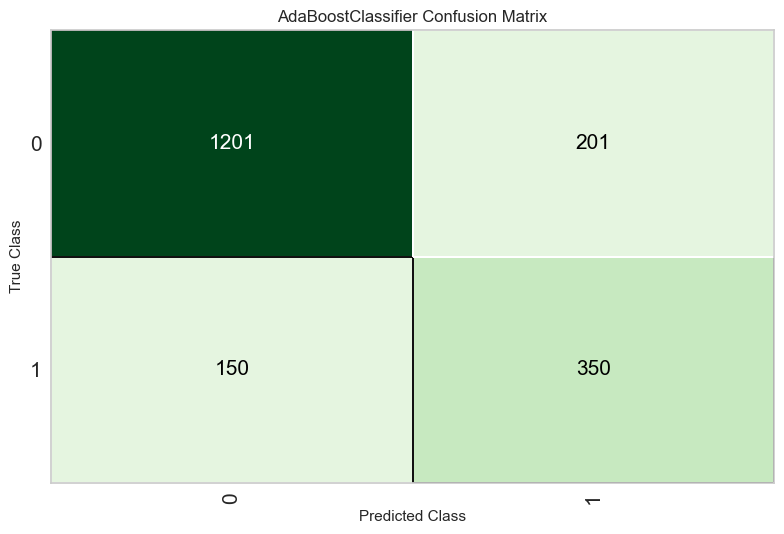

In [28]:
plot_model(model_ada, plot='confusion_matrix')

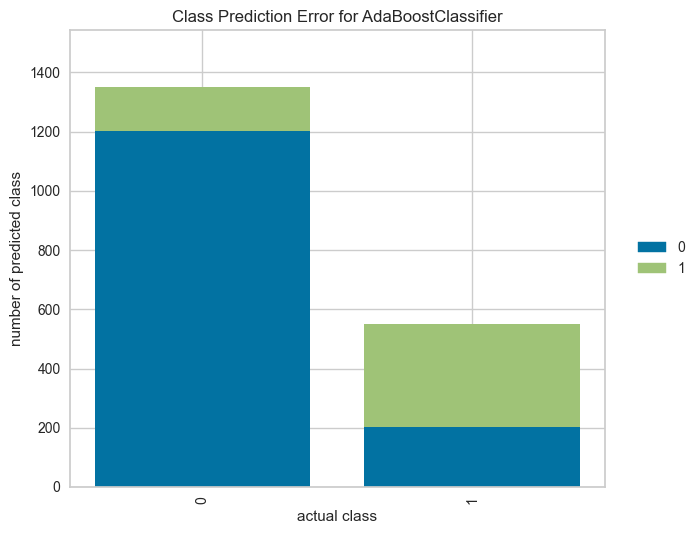

In [29]:
plot_model(model_ada, plot='error')

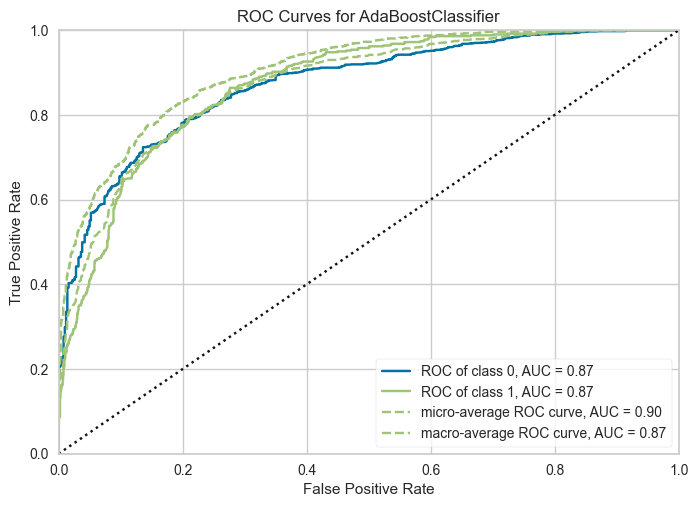

In [41]:
plot_model(model_ada, plot='auc')

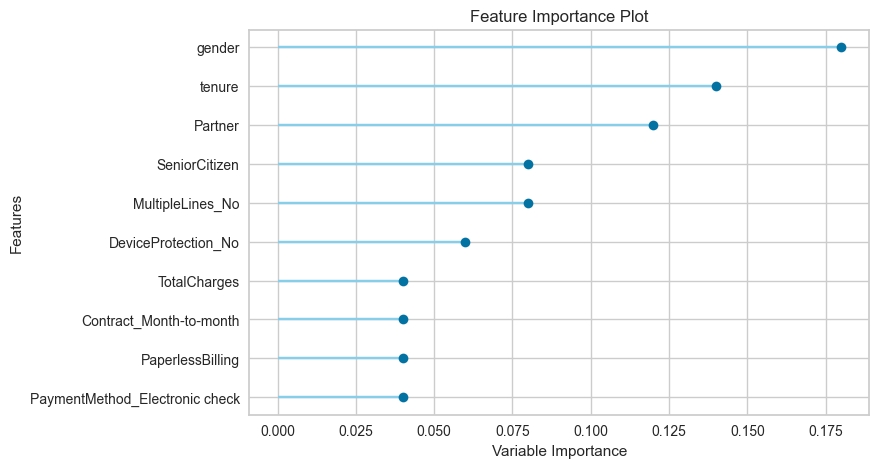

In [32]:
plot_model(model_ada, plot='feature')

#### Model with Recall Optimization (Logistic Regression)

In [67]:
model_lr = create_model('lr')
model_lr = tune_model(model_lr, optimize='recall', n_iter=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7815,0.8490,0.7051,0.5690,0.6298,0.4773,0.4828
1,0.7948,0.8670,0.7854,0.5810,0.6679,0.5242,0.5367
2,0.7802,0.8491,0.7210,0.5638,0.6328,0.4792,0.4866
3,0.7362,0.8067,0.6352,0.4983,0.5585,0.3743,0.3799
4,0.7734,0.8552,0.7597,0.5497,0.6378,0.4790,0.4923
Mean,0.7732,0.8454,0.7213,0.5523,0.6254,0.4668,0.4757
Std,0.0198,0.0205,0.0515,0.0288,0.0361,0.0495,0.0517


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7714,0.8451,0.7564,0.5480,0.6355,0.4751,0.4882
1,0.7880,0.8692,0.8112,0.5676,0.6678,0.5192,0.5371
2,0.7689,0.8553,0.7511,0.5435,0.6306,0.4687,0.4817
3,0.7418,0.8117,0.6996,0.5062,0.5874,0.4065,0.4177
4,0.7678,0.8615,0.8069,0.5387,0.6460,0.4833,0.5051
Mean,0.7676,0.8485,0.7650,0.5408,0.6335,0.4706,0.4860
Std,0.0148,0.0201,0.0411,0.0199,0.0264,0.0365,0.0391


Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [68]:
y_pred_lr = model_lr.predict(X_test)
y_pred_lr_proba = model_lr.predict_proba(X_test)

print("Accuracy:", model_lr.score(X_test, y_test))
print("roc-auc:", roc_auc_score(y_test, y_pred_lr_proba[:, 1]))
print(classification_report(y_test, y_pred_lr))

Accuracy: 0.7943262411347518
roc-auc: 0.8668576923831766
              precision    recall  f1-score   support

           0       0.90      0.80      0.85       502
           1       0.61      0.77      0.68       203

    accuracy                           0.79       705
   macro avg       0.76      0.79      0.77       705
weighted avg       0.82      0.79      0.80       705



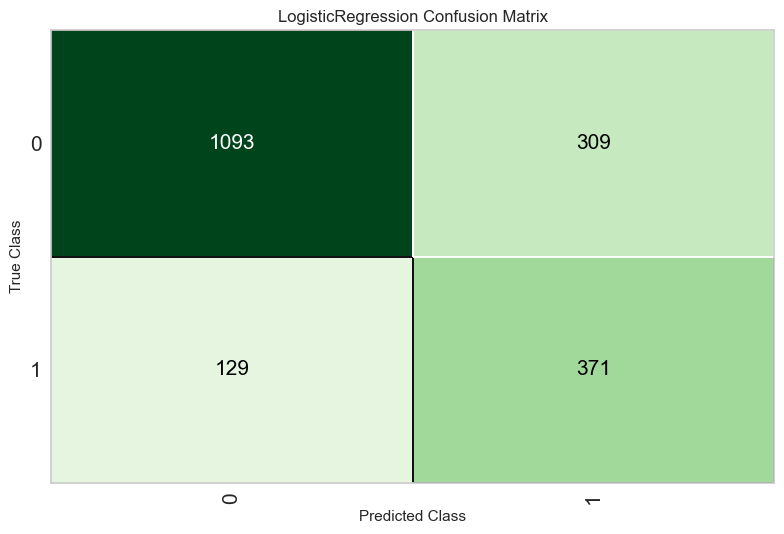

In [69]:
plot_model(model_lr, plot='confusion_matrix')

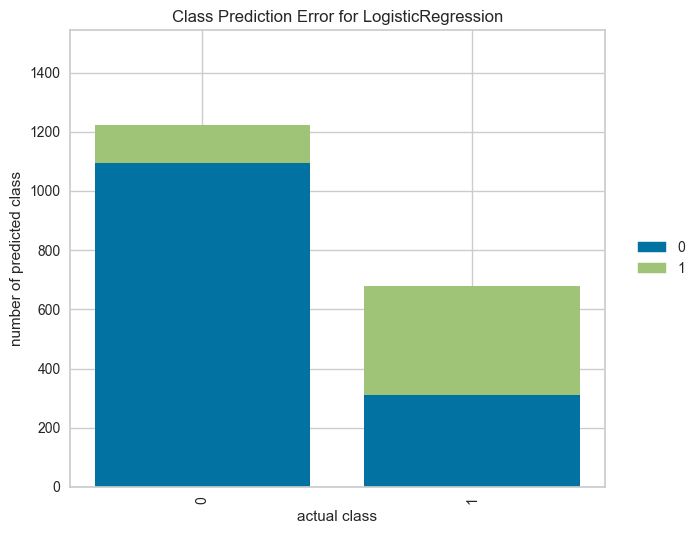

In [70]:
plot_model(model_lr, plot='error')

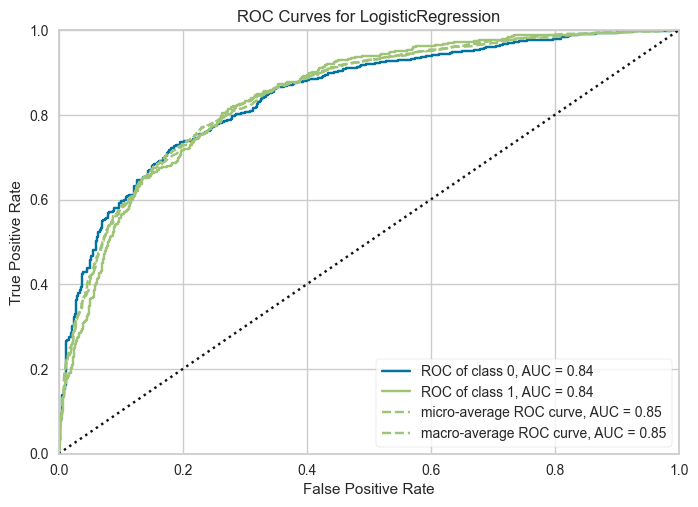

In [71]:
plot_model(model_lr, plot='auc')

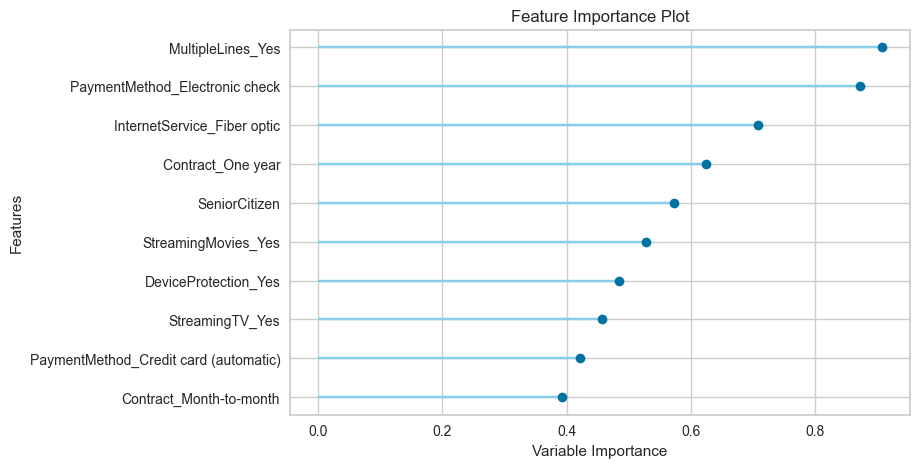

In [72]:
plot_model(model_lr, plot='feature')

### Conclusions

In [84]:
correlations = get_config("X_train_transformed")
correlations['churn'] = get_config("y_train_transformed")
corr = correlations.corr()['churn'].sort_values(ascending=False)

In [129]:
corr

churn                                      1.000000
Contract_Month-to-month                    0.473564
OnlineSecurity_No                          0.394782
TechSupport_No                             0.379638
PaymentMethod_Electronic check             0.356677
InternetService_Fiber optic                0.345420
OnlineBackup_No                            0.320032
DeviceProtection_No                        0.290387
SeniorCitizen                              0.219359
MonthlyCharges                             0.219340
PaperlessBilling                           0.205304
StreamingMovies_No                         0.170540
StreamingTV_No                             0.165247
StreamingTV_Yes                            0.103288
StreamingMovies_Yes                        0.097674
MultipleLines_Yes                          0.069394
gender                                     0.022606
MultipleLines_No phone service             0.012370
PhoneService                              -0.009343
DeviceProtec

In [91]:
corr[["gender", "SeniorCitizen", "Partner", "Dependents"]]

gender           0.022606
SeniorCitizen    0.219359
Partner         -0.151428
Dependents      -0.108594
Name: churn, dtype: float64